# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

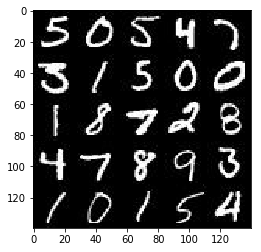

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

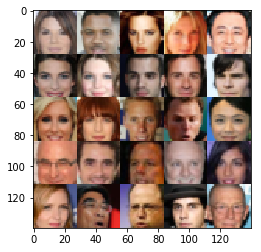

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeb_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeb_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Set alpha for leaky relu
        alpha = 0.12
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # Set alpha for leaky relu
        alpha = 0.12      
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_fake, d_logits_fake = discriminator(g_model)
    d_model_real, d_logits_real = discriminator(input_real, reuse=True)
    
    smooth = 0.1

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # Set number of images for generating sample faces and step count.
    n_images = 25
    steps = 0
       
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Scale batch_images to [-1, 1]
                batch_images *= 2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, 
                                               input_real: batch_images,
                                               lr: learning_rate})

                # At every 10 batches, print training losses for D and G
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                # Show generator output every 100 batches
                if steps % 100 == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[-1], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5851... Generator Loss: 5.5827
Epoch 1/2... Discriminator Loss: 7.5724... Generator Loss: 0.0009
Epoch 1/2... Discriminator Loss: 2.1151... Generator Loss: 0.2017
Epoch 1/2... Discriminator Loss: 2.1419... Generator Loss: 4.9161
Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 5.3166
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 0.6330... Generator Loss: 2.0329
Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 0.6186... Generator Loss: 3.0654
Epoch 1/2... Discriminator Loss: 1.6805... Generator Loss: 6.9813


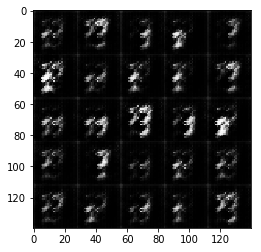

Epoch 1/2... Discriminator Loss: 1.8195... Generator Loss: 0.3612
Epoch 1/2... Discriminator Loss: 0.7572... Generator Loss: 1.7508
Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 4.4934
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 4.8463
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 0.9521
Epoch 1/2... Discriminator Loss: 0.8328... Generator Loss: 1.2452
Epoch 1/2... Discriminator Loss: 1.6453... Generator Loss: 0.4193
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 1.6266... Generator Loss: 0.3961


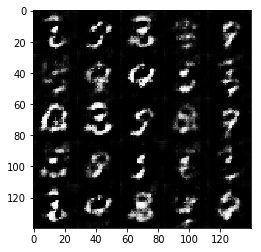

Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.8426
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 1.7397
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 1.3917
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 1.8997
Epoch 1/2... Discriminator Loss: 1.1734... Generator Loss: 1.2862
Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.6417
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.5427
Epoch 1/2... Discriminator Loss: 1.3656... Generator Loss: 0.6283
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.7121
Epoch 1/2... Discriminator Loss: 1.4807... Generator Loss: 0.4493


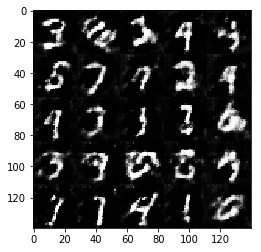

Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.5573
Epoch 1/2... Discriminator Loss: 1.5756... Generator Loss: 0.4071
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 0.5704
Epoch 1/2... Discriminator Loss: 1.5773... Generator Loss: 0.4256
Epoch 1/2... Discriminator Loss: 1.0500... Generator Loss: 1.1125
Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 2.1690
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 1.1186
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 1.7221
Epoch 1/2... Discriminator Loss: 1.0823... Generator Loss: 1.3480
Epoch 1/2... Discriminator Loss: 1.1602... Generator Loss: 1.3264


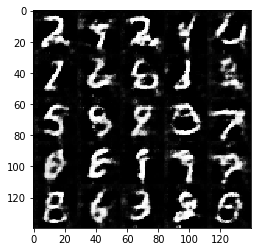

Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 1.9350
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 1.2285
Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 1.0514
Epoch 1/2... Discriminator Loss: 1.6367... Generator Loss: 0.3789
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 1.4043
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 1.7855
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 1.0573
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 2.1790
Epoch 1/2... Discriminator Loss: 1.1333... Generator Loss: 1.3471
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 0.9074


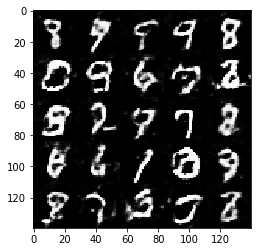

Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 1.6072
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.7446
Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 0.4408
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.5260... Generator Loss: 0.4079
Epoch 1/2... Discriminator Loss: 1.7072... Generator Loss: 0.3421
Epoch 1/2... Discriminator Loss: 1.5500... Generator Loss: 0.4320
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.5645
Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 0.9334
Epoch 1/2... Discriminator Loss: 1.5320... Generator Loss: 1.5968


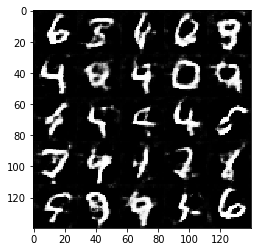

Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 0.8957
Epoch 1/2... Discriminator Loss: 1.6691... Generator Loss: 0.3441
Epoch 1/2... Discriminator Loss: 1.5218... Generator Loss: 0.4047
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 0.6685
Epoch 1/2... Discriminator Loss: 1.7687... Generator Loss: 0.2999
Epoch 1/2... Discriminator Loss: 1.3297... Generator Loss: 0.5551
Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 0.5800
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 1.7355
Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 1.2769
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 0.7950


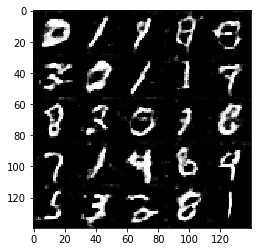

Epoch 1/2... Discriminator Loss: 1.1631... Generator Loss: 1.4484
Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 1.2093
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 1.7837
Epoch 1/2... Discriminator Loss: 1.0726... Generator Loss: 1.0328
Epoch 1/2... Discriminator Loss: 1.4892... Generator Loss: 1.7680
Epoch 1/2... Discriminator Loss: 1.2031... Generator Loss: 1.1825
Epoch 1/2... Discriminator Loss: 1.5355... Generator Loss: 0.4048
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.5077
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.4823
Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.5381


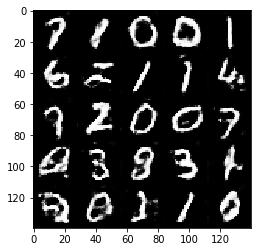

Epoch 1/2... Discriminator Loss: 1.3474... Generator Loss: 0.5385
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 1.9194
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 1.1342
Epoch 1/2... Discriminator Loss: 1.1803... Generator Loss: 1.1162
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 1.6915
Epoch 1/2... Discriminator Loss: 1.1946... Generator Loss: 1.2629
Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 1.0583
Epoch 1/2... Discriminator Loss: 1.1598... Generator Loss: 1.2078
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 1.2238
Epoch 1/2... Discriminator Loss: 1.5108... Generator Loss: 2.1075


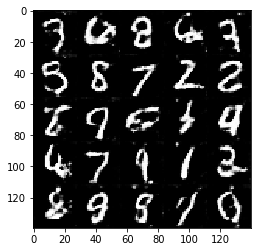

Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 0.6844
Epoch 1/2... Discriminator Loss: 1.4249... Generator Loss: 0.4681
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.4316
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.6016
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.5086
Epoch 2/2... Discriminator Loss: 1.5615... Generator Loss: 0.4195
Epoch 2/2... Discriminator Loss: 1.1974... Generator Loss: 0.6335
Epoch 2/2... Discriminator Loss: 1.4383... Generator Loss: 0.4887
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 0.8434
Epoch 2/2... Discriminator Loss: 1.1551... Generator Loss: 1.1828


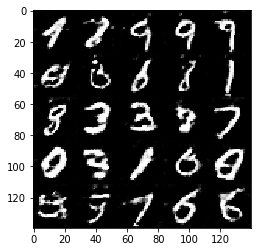

Epoch 2/2... Discriminator Loss: 1.7064... Generator Loss: 2.5473
Epoch 2/2... Discriminator Loss: 1.1149... Generator Loss: 0.8623
Epoch 2/2... Discriminator Loss: 1.6731... Generator Loss: 0.3511
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 1.6273
Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 1.6600
Epoch 2/2... Discriminator Loss: 1.1654... Generator Loss: 1.6124
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 1.2161
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 1.6554
Epoch 2/2... Discriminator Loss: 1.1638... Generator Loss: 1.2660
Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 1.9110


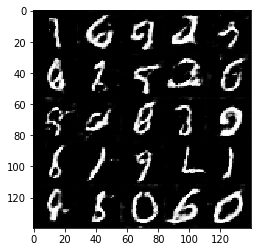

Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 1.2693
Epoch 2/2... Discriminator Loss: 2.0772... Generator Loss: 0.2192
Epoch 2/2... Discriminator Loss: 1.2883... Generator Loss: 0.5452
Epoch 2/2... Discriminator Loss: 1.4245... Generator Loss: 0.5077
Epoch 2/2... Discriminator Loss: 1.5219... Generator Loss: 0.4649
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.5157
Epoch 2/2... Discriminator Loss: 1.9037... Generator Loss: 0.3042
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 1.6530
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 1.5108
Epoch 2/2... Discriminator Loss: 0.9500... Generator Loss: 1.0439


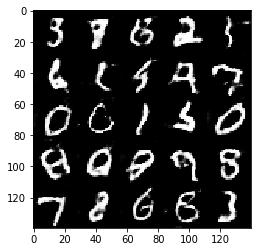

Epoch 2/2... Discriminator Loss: 2.6336... Generator Loss: 3.0459
Epoch 2/2... Discriminator Loss: 1.2025... Generator Loss: 0.8273
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.6896
Epoch 2/2... Discriminator Loss: 1.2898... Generator Loss: 0.5712
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.5685
Epoch 2/2... Discriminator Loss: 1.0678... Generator Loss: 0.9728
Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 1.3406
Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 1.7650
Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 1.3317
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 0.5556


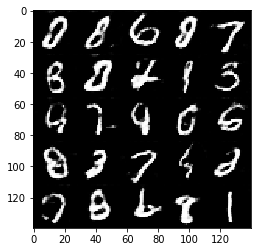

Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 0.4592
Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 0.6234
Epoch 2/2... Discriminator Loss: 1.5113... Generator Loss: 0.4326
Epoch 2/2... Discriminator Loss: 1.2617... Generator Loss: 1.5560
Epoch 2/2... Discriminator Loss: 1.2138... Generator Loss: 1.9786
Epoch 2/2... Discriminator Loss: 1.1344... Generator Loss: 1.6764
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 1.2482
Epoch 2/2... Discriminator Loss: 1.5033... Generator Loss: 0.4895
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.7587
Epoch 2/2... Discriminator Loss: 1.5972... Generator Loss: 0.4030


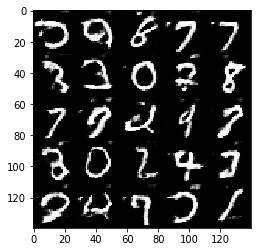

Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 0.7352
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.4870
Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 0.9867
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.5941
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.5072
Epoch 2/2... Discriminator Loss: 1.4039... Generator Loss: 0.4971
Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.5212
Epoch 2/2... Discriminator Loss: 1.4465... Generator Loss: 0.5009
Epoch 2/2... Discriminator Loss: 1.5592... Generator Loss: 0.4102


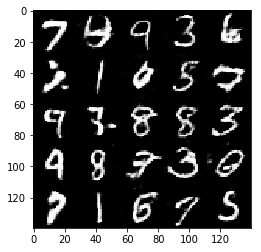

Epoch 2/2... Discriminator Loss: 1.2806... Generator Loss: 0.5940
Epoch 2/2... Discriminator Loss: 1.5583... Generator Loss: 0.4170
Epoch 2/2... Discriminator Loss: 1.0738... Generator Loss: 0.8176
Epoch 2/2... Discriminator Loss: 1.5505... Generator Loss: 0.4179
Epoch 2/2... Discriminator Loss: 1.7533... Generator Loss: 0.3250
Epoch 2/2... Discriminator Loss: 1.0938... Generator Loss: 0.7891
Epoch 2/2... Discriminator Loss: 1.1397... Generator Loss: 0.6661
Epoch 2/2... Discriminator Loss: 1.5952... Generator Loss: 0.3870
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 0.6610
Epoch 2/2... Discriminator Loss: 1.5552... Generator Loss: 0.4357


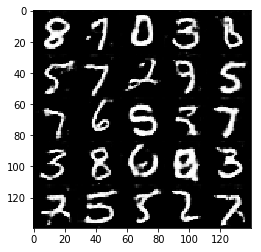

Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.5764
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.4900
Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 0.6225
Epoch 2/2... Discriminator Loss: 1.8214... Generator Loss: 0.3113
Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 0.6609
Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 1.6516
Epoch 2/2... Discriminator Loss: 1.0086... Generator Loss: 1.0831
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.5290
Epoch 2/2... Discriminator Loss: 1.1716... Generator Loss: 1.9313


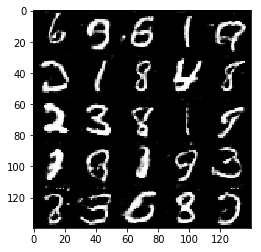

Epoch 2/2... Discriminator Loss: 0.9348... Generator Loss: 1.2795
Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 1.5146
Epoch 2/2... Discriminator Loss: 0.9458... Generator Loss: 1.3555
Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 2.4152
Epoch 2/2... Discriminator Loss: 0.8751... Generator Loss: 2.1441
Epoch 2/2... Discriminator Loss: 1.1183... Generator Loss: 1.7251
Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 1.3282
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 1.2542
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.8960
Epoch 2/2... Discriminator Loss: 0.9373... Generator Loss: 1.7490


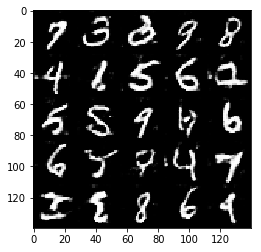

Epoch 2/2... Discriminator Loss: 1.1784... Generator Loss: 0.6707
Epoch 2/2... Discriminator Loss: 1.0740... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.5237... Generator Loss: 0.4573
Epoch 2/2... Discriminator Loss: 1.2448... Generator Loss: 0.6091
Epoch 2/2... Discriminator Loss: 0.9467... Generator Loss: 1.1658
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 2.8662
Epoch 2/2... Discriminator Loss: 0.9518... Generator Loss: 1.5161


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.4747
Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.7806
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 2.6672
Epoch 1/1... Discriminator Loss: 0.4646... Generator Loss: 4.5405
Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 6.9638
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 2.3869
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 2.8736
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 2.8282
Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 6.5362
Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 4.2189


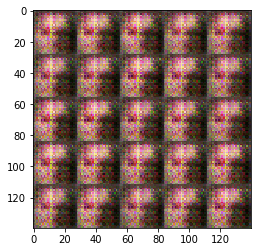

Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 2.6785
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 3.2672
Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 4.3647
Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 3.2228
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 3.6883
Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 2.4641
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 2.7635
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 4.3713
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 4.0325
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.9388


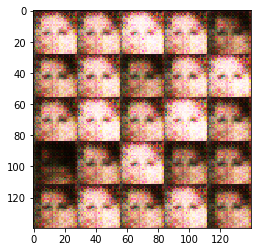

Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.4812
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.1345
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 2.6144
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 2.2403
Epoch 1/1... Discriminator Loss: 0.5965... Generator Loss: 2.2347
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 1.7869
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.8446
Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 2.7687
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.3791


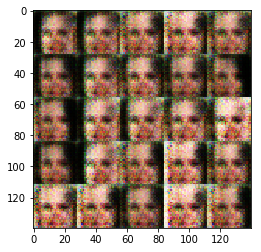

Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 2.9406
Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 2.2937
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.6761
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.4259
Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.9843
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.5047
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 3.3954
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.7906
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7775


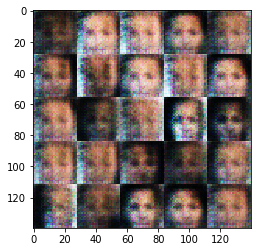

Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.4972
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.8639
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.9194
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 2.2184
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.8407
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 1.3684
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 3.5861


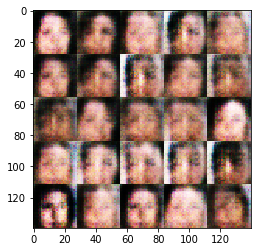

Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 2.4885
Epoch 1/1... Discriminator Loss: 0.7606... Generator Loss: 1.4964
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 2.5071
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.9622
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.6684
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.6518
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 1.9080


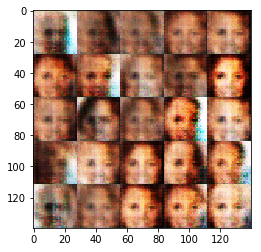

Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.3933
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 1.3962
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.9709
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.8625
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 2.1907
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 2.6057


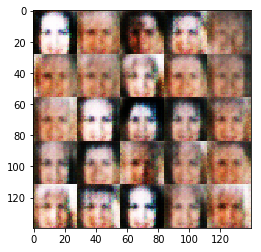

Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.5330
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.4606
Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 1.3849
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 1.6455
Epoch 1/1... Discriminator Loss: 0.6696... Generator Loss: 1.9095
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.8212
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.5479
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.8265


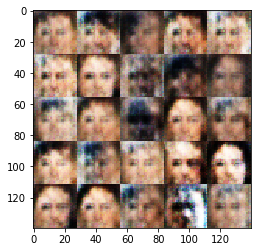

Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.5576
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 2.7770
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 1.4886
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.4334
Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 2.1278
Epoch 1/1... Discriminator Loss: 0.7276... Generator Loss: 1.7326
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 2.1639
Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.0793


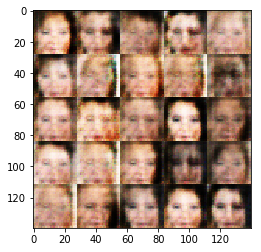

Epoch 1/1... Discriminator Loss: 0.7986... Generator Loss: 2.1131
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.8753
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 1.8489
Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 2.2957
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.5913
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 1.5626
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.8802
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.8568


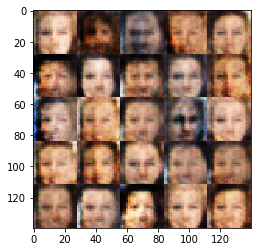

Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.4622
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 2.2050
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.6230
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.2763
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 2.5322


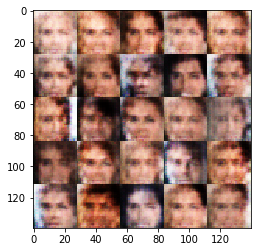

Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.3384
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 1.1200
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.6140
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.1805
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.1833
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.8450


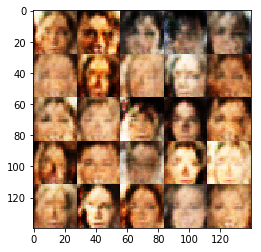

Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.4414
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.5461
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.7446
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.5730


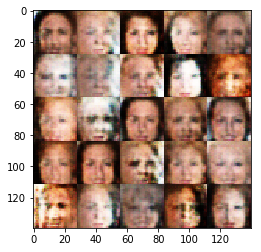

Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 1.5220
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.7421
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.6491
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.4640
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 2.9765


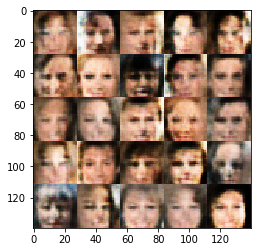

Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.2753
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.2823
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.6383
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.4018
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.0774
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.4784


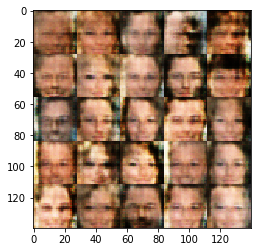

Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 1.2889
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 1.5342
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.4686
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.3851
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.8725
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 1.2510
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.7593


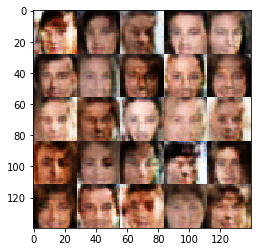

Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 1.4898
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.9751
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.8113
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.1385


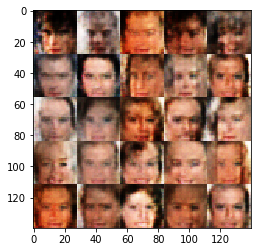

Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.8781
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.6338
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 1.3926
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.4878


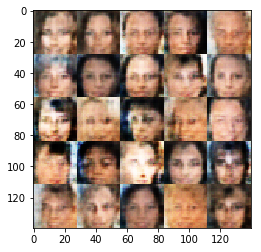

Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.7113
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.1770
Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 1.4799
Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 1.4680
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.3279
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.6071
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.8303
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.2462


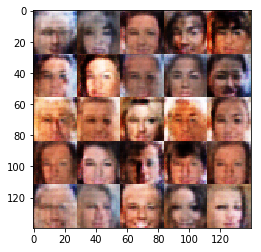

Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 1.7049
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.9299
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.9291
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.6404
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.2866


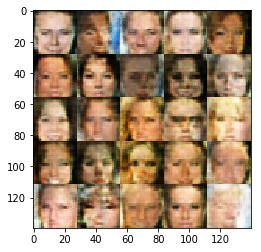

Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.2059
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 1.7756
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.4735
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.3023
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.3712
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.8786


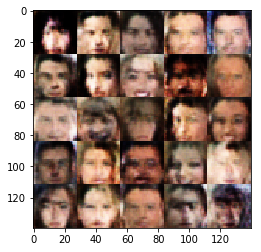

Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 1.5024
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.4053
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 1.5975
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 1.6538


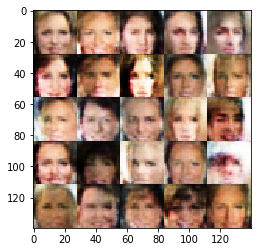

Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.4748
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.4652
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.9250
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 1.7298
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.2884
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.7474


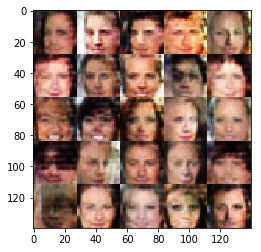

Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 2.0755
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.4197
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.5248
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.2295
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.6171
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.1105
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 1.2424


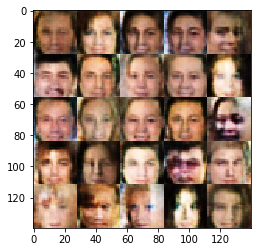

Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.6352
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.4903
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.6745... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.3220


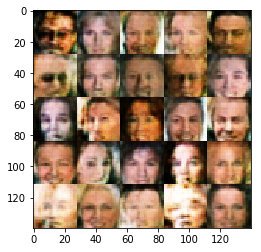

Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 3.1432
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 1.9038
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 1.7352
Epoch 1/1... Discriminator Loss: 0.7206... Generator Loss: 2.1186


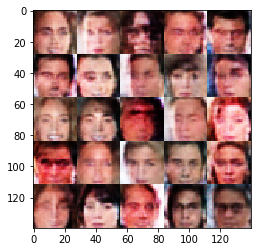

Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.3018
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.6850
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.8884
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 2.0599
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 1.7771


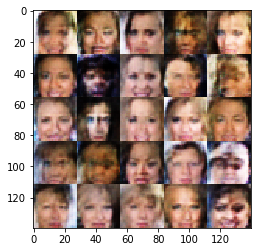

Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.5557
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 2.1777
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 1.3611
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.5639
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.5367
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.9852


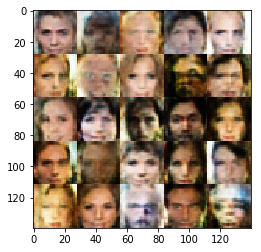

Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.4642
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 0.7520... Generator Loss: 2.5903
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.5050
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.2872
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.7634
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.2794
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 2.0167


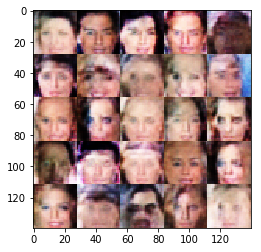

Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.7081
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 1.3394
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.9135
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.5073


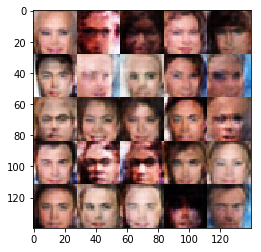

Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 2.0991
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 1.5419
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.2599


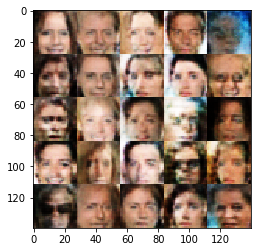

Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 1.9939
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.3395
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.1868


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.